# Intro

This notebook uses the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset to showcase what can be called, with some over-simplification, "Stable Diffusion from scratch." To be more precise I will showcase a handmade variational autoencoder and a simple diffusion model that's based on Stable Diffusion, and which generates images resembling the training data, given a category (e.g. t-shirt, coat, sandal). The diffusion model is a UNet with embedded category and time information, built out of ResBlocks with self-attention. The final result will be a model which can receive as input which category of image you want to generate (like "T-shirt"), and produce a fictitious version of that image. Real stable diffusion can take whole phrases and use CLIP embeddings to provide the guide the denoising process, I have not implemented this yet.

To build a _latent diffusion_ model, we would train the diffusion model on the latents of the training set and, when sampling from the model, decode the generated latent into the output image. For images as small as Fashion-MNIST however, this is unnecessary. For high resolution images it would be necessary to train on the latents because their reduced dimensionality makes the computation more tractable. We will build a VAE to encode/decode latents _and even to generate very rough images_, but those latents won't be part of diffusion, and the diffusion model is a much better image generator than the VAE alone.

This project is the result of my completing fast.ai's [machine learning course](https://course.fast.ai) taught by Jeremy Howard, which is where I learned how to write the components inside. There are three sources of code here:
 - diy_stable_diffuion: my library which I wrote as part of doing the course, and from which I import important components such as the Learner framework.
 - Components I've implemented that are embedded directly into this notebook: I've chosen to showcase these here especially
   - Multi-headed self-attention
   - ResBlocks
   - UNet
   - Variational Autoencoder
   - The forward (diffusion) and backwards (sampling) processes of class-conditioned DDIM image generation
 - components imported from libraries such as pytorch. The course I followed taught us how to build "stable diffusion from scratch", meaning we wrote everything from matrix multiplication to back-propagation using only the python and its standard libraries (this progress is visible in the notebooks under the ./nbs directory), but after having implemented working versions of them, we have at times switched to the highly optimized versions of these components made available by pytorch.

# What's Fashion-MNIST? What will we do with it?

Here is a labeled selection of images from Fashion-MNIST:

In [10]:
from datasets import load_dataset
from diy_stable_diffusion.datasets import *
import matplotlib.pyplot as mpl
dsd = load_dataset("fashion_mnist")
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

Reusing dataset fashion_mnist (/root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [23]:
ims=dsd['train']['image'][:16]
labels=dsd['train']['label'][:16]

In [24]:
lbl_names = dsd['train'].features['label'].names

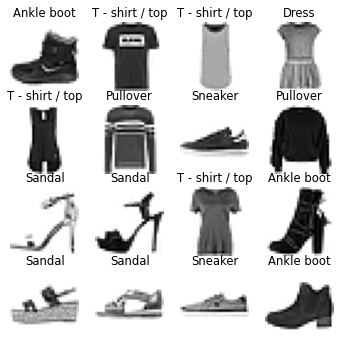

In [25]:
show_images(ims, titles=[lbl_names[lbl] for lbl in labels], imsize=1.5)

The images are 1-channel 28x28 images meant to be a slightly richer dataset than the classic MNIST dataset of handwritten digits (the dimensions and number of categories were chosen to match MNIST).

We will write and train a diffusion model which, given a category label representing, for example, "Sneaker" will generate a brand new such image. In order to showcase another component which is essential for modern generative image models, we will also build and train a Variational Autoencoder for these images.

# VAE

The goal of an autoencoder is to learn at once a way to encode an image into a smaller dimensionality than the original image, called a latent space, and to be able to decode from that latent into the original image. This means the model learns a certain type of efficient but not lossless compression of the information in the image, and a way to uncompress it.

A Variational Autoencoder adds the characteristic that the latent space consists in tensors which resemble Gaussian noise. Then actual Gaussian noise can be sampled from the shape of the latent space and decoded into outputs which resemble training data. This also adds robustness to the encoder and decoder because instead of having a latent space where the decoder can only decode points precisely corresponding to the training data, the model must learn to effectively decode regions in the latent space in a "spherical" region surrounding those points.

## Model

In [27]:
import torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy,Mean,Metric
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from einops import rearrange

from diy_stable_diffusion.learner import *
from diy_stable_diffusion.activations import *
from diy_stable_diffusion.training import *
from diy_stable_diffusion.init import *
from diy_stable_diffusion.conv import *
from diy_stable_diffusion.sgd import *
from diy_stable_diffusion.resnet import *
from diy_stable_diffusion.augment import *
from diy_stable_diffusion.accel import *

from diy_stable_diffusion.utils import *

from fastprogress import progress_bar

A helper function to create a layer which performs activation and normalization of data after running it through a linear layer.

In [28]:
def lin(n_in, n_out, act=nn.SiLU, norm=nn.BatchNorm1d, bias=True):
    layers = nn.Sequential(nn.Linear(n_in, n_out, bias=bias))
    if act:
        layers.append(act())
    if norm:
        layers.append(norm(n_out))
    
    return layers

We want to initialize weights so that they will be able to produce activations with mean and unit variance. If all layers are such initialized and receive 0-mean-unit-variance inputs, then we can prevent the variance and means from either exploding or vanishing.

In [29]:
def init_weights(module, leaky=0.2):
    if isinstance(module, (nn.Conv1d, nn.Conv2d, nn.Linear)):
        init.kaiming_normal_(module.weight, a=leaky)

Here is the actual VAE model. A simple linear encoder and decoder can do the job here. This model will take flattened versions of the images (28x28 pixels flattened to 784 length vectors), and encode them into latents of size 196 (so we can later visualize the latents as 14x14 images).

In [30]:
class VAE(nn.Module):
    def __init__(self):
        # remember to call init on module
        super().__init__()
        
        n_in = 784 # 28x28, original size of fashion mnist images
        n_hidden=400
        n_latents=196 # chosen since it can be visualized as a square more easily
        # enc: in to hidden
        self.enc = nn.Sequential(
            lin(n_in, n_hidden),
            lin(n_hidden, n_hidden)
        )

        # mu, lv: hidden to latent size
        self.mu = lin(n_hidden, n_latents, act=None)
        self.lv = lin(n_hidden, n_latents, act=None)

        # dec: latent back to in
        self.dec = nn.Sequential(
            lin(n_latents, n_hidden),
            lin(n_hidden, n_hidden),
            lin(n_hidden, n_in, act=None) # remember act=None for output layers
        )

        # remember to initialize weights
        self.apply(init_weights)
    
    def forward(self, x):
        x = self.enc(x)
        
        mu_x = self.mu(x)
        lv_x = self.lv(x)
        x = mu_x + (lv_x/2).exp() * torch.randn_like(mu_x)
        
        return self.dec(x), mu_x, lv_x # return mu, lv in order to run loss funcs incorporating them

Here are the loss functions we will use. First is KL Divergence Loss, which serves to train the mu (mean) and lv (log variance) layers to resemble a normal distribution. Minimizing kdl_loss means minimizing the KL Divergence between the means and variances represented by the output of those layers and a distribution that actually has 0-mean and unit variance.

In [31]:
'''
inp = tuple (x, mu_x, lv_x)
targ = target image
'''
def kdl_loss(inp, _):
    _, mu_x, lv_x = inp
    # var = (lv_x).exp()
    # return -0.5 * (1 + lv_x - mu_x**2 - var).mean()
    return -0.5 * (1 + lv_x - mu_x.pow(2) - lv_x.exp()).mean()

Because the output has to be near to the input, we also include a loss term for the Binary Cross-Entropy between the output and the input, interpretted as logits (since, when we train this model, input vectors will have values in the range \[0, 1\]. We add the two loss functions together for the final loss which the model will learn to minimize.

In [32]:
'''
inp = tuple (x, mu_x, lv_x)
targ = target image
'''
def bce_loss(inp, targets):
    return F.binary_cross_entropy_with_logits(inp[0], targets)

'''
inp = tuple (x, mu_x, lv_x)
targ = target image
'''
def vae_combined_loss(inp, act_x):
    return kdl_loss(inp, act_x) + bce_loss(inp, act_x)

And finally, just to have another way to track model quality during training, we have a helper function to calculate MSE between output and input images. The model won't actually minimize this loss though, it's just a metric we will track.

In [33]:
'''
Not used for loss function, just a metric to track model quality
'''
def mse(inp, targets):
    return F.mse_loss(inp[0], targets)

## Data Preparation

Here we are going to take the Dataset Dictionary containing the training and validation data, transform the data into 1-dimensional tensors, and form them into a pair of DataLoaders (one for training data, the other for validation data). Both of these two DataLoader objects are held for convenience in one "DataLoaders" object here called dls_vae.

In [34]:
batch_size_vae = 256
@inplace
def transformi_vae(b):
    '''
    Transform the dictionary dataset to have x and y values that both
    are a flattened version of the input image, in range [0,1], as
    tensors.
    '''
    img = [TF.to_tensor(o).flatten() for o in b['image']]
    b['label'] = b['image'] = img

tds_vae = dsd.with_transform(transformi_vae)
dls_vae = DataLoaders.from_dd(tds_vae, batch_size_vae, num_workers=8)

Parameter 'transform'=<function inplace.<locals>._f at 0x7fc03007b430> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Let's grab a batch of x and y data from the training dataloader...

In [35]:
xb, yb = next(iter(dls_vae.train))
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 784]))

And since we've already changed them into 1-d tensors, we'll take just a few from both the x and the y batches, reshape them back into 28x28, and look at them to make sure oout dataloader is doing what we expect. Notice that in each batch the x and y images are the same.

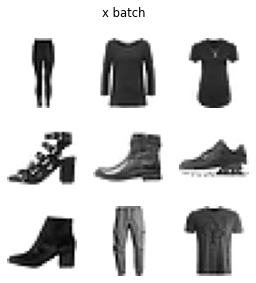

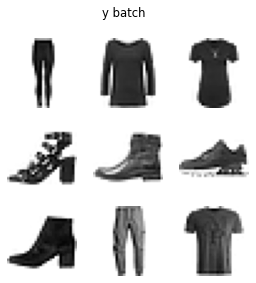

In [36]:
show_images(xb[:9].view(-1, 1, 28, 28), imsize=1.5, suptitle="x batch")
show_images(yb[:9].view(-1, 1, 28, 28), imsize=1.5, suptitle="y batch")

## Training

Here we test a range of learning rates using the lr_find() tool that's in the Learner framework from diy_stable_diffusion. We want to pick a learning rate at which we find loss to be decreasing steadily.

After experimenting with some of the learning rates suggested by this tool, I found 1e-1 was too aggressive and failed to converge, but 3e-2 gave satisfactory results.

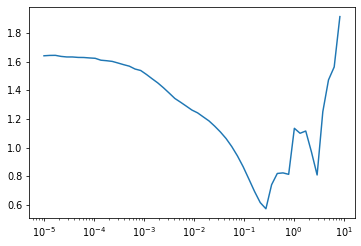

In [42]:
'''
Use adam optimizer for gradient updates.
'''
adam_opt=partial(optim.Adam, eps=1e-5)

model=VAE()
'''
Do SGD with progressively increasing learning rates and use a learning rate at which loss function has a steep slope
'''
lr_finder_cbs = [
    DeviceCB(), # move model and input tensors to cuda device if possible
    MixedPrecision() # Mixed half and full precision
]
lr_finding_learner=Learner(model, dls_vae, loss_func=vae_combined_loss, lr=None, cbs=lr_finder_cbs, opt_func=adam_opt)
lr_finding_learner.lr_find()

And finally lets add this little helper to track some custom metrics during training.

In [40]:
class FuncMetric(Mean):
    def __init__(self, fn, device=None):
        super().__init__(device=device)
        self.fn = fn
    
    def update(self, inp, targets):
        self.weighted_sum += self.fn(inp, targets)
        self.weights += 1

TODO: input data augmentation

The Learner class from diy_stable_diffusion.learner performs the SGD optimization loop. It's a flexible framework that accepts many types of callbacks which can hook before or after the processing of batches, epochs, or the whole training loop. We're using a learning rate scheduler from Leslie Smith's [Superconvergence paper](https://arxiv.org/abs/1708.07120), along with Adam optimization.

In [43]:
max_lr = 3e-2

'''
Use 1-cycle learning rate schedule [https://arxiv.org/abs/1708.07120]
'''
epochs=25
n_training_steps = epochs * len(dls_vae.train) # epochs * batches_per_epoch
schedule = partial(lr_scheduler.OneCycleLR, total_steps=n_training_steps, max_lr=max_lr)
scheduler_cb = BatchSchedCB(schedule)
'''
Track custom metrics in addition to ultimate loss function: KDL loss, binary cross entropy loss, and MSE (as an additional way
to track autoencoder quality during training)
'''
metrics_cb = MetricsCB(kd_loss=FuncMetric(kdl_loss), bce_loss=FuncMetric(bce_loss), mse=FuncMetric(mse))
training_cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), metrics_cb, scheduler_cb]
model=VAE()
learner=Learner(model, dls_vae, loss_func=vae_combined_loss, lr=max_lr, cbs=training_cbs, opt_func=adam_opt)

First we train it, then save the model to reload it for when restarting the notebook. But let's test what the final metrics are, after loading the model from disk, by passing over the validation set 1 time.

kd_loss,bce_loss,mse,loss,epoch,train
0.034,0.307,20.347,0.342,0,eval


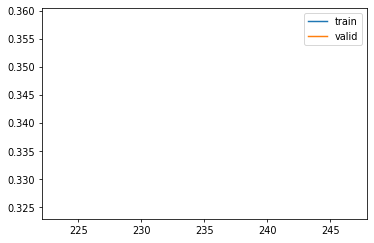

In [44]:
# learner.fit(epochs)
# saveobj(model.state_dict(), 'fmnist-vae')
model = VAE(); model.load_state_dict(torch.load('models/2024-01-29-fmnist-vae-651734a5.pkl'))
model=model.cuda()
learner.model=model
learner.fit(1, do_train=False, do_validate=True)

## Demo

Get the autoencoded results of a batch of validation data, and resize a few of them as 1-channel, 28x28 images

In [45]:
model.eval()
res=model(yb.cuda())[0].cpu()
res = res[:25].view(-1, 1, 28, 28)

Check some stats...

In [46]:
res.min(), res.max(), res.sigmoid().min(), res.sigmoid().max()

(tensor(-12.5147, grad_fn=<MinBackward1>),
 tensor(3.3203, grad_fn=<MaxBackward1>),
 tensor(3.6724e-06, grad_fn=<MinBackward1>),
 tensor(0.9651, grad_fn=<MaxBackward1>))

Some of the values are far outside the \[0, 1\] input range, so let's interpret the outputs as sigmoids. It's possible to put a sigmoid layer in the decoder, but I found worse results while training that way.

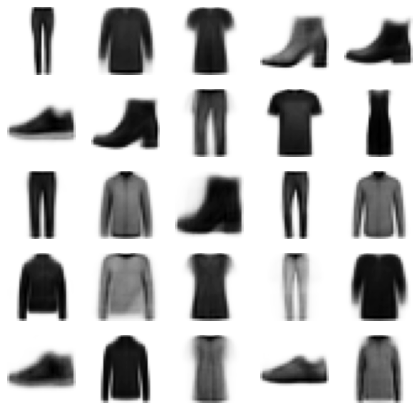

In [47]:
show_images(res.sigmoid(), imsize=1.5)

Now lets get a sense for what's happening inside the latents. We'll reshape them as 14x14 images and display them.

Ideally I would have put the mu and lv layers inside the encoder, but for simplicity's sake they're separate, so we'll stitch together the model's encoder and mu layers right now to see what the latents' means are.

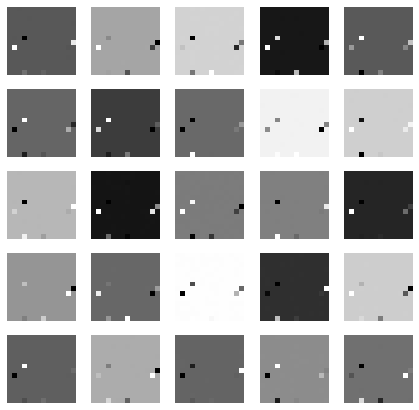

In [48]:
encoder_with_mu = nn.Sequential(model.enc, model.mu)
latents = encoder_with_mu(xb.cuda()).cpu()
latents = latents[:25].view(-1, 1, 14, 14)
show_images(latents, imsize=1.5)

Interestingly, almost all of the information in the latents seems to be encoded in the same six spots in the features vector, along with a "background information" which is constant throughout the rest of the vector.

Now, what happens if we sample from actual Gaussian noise?

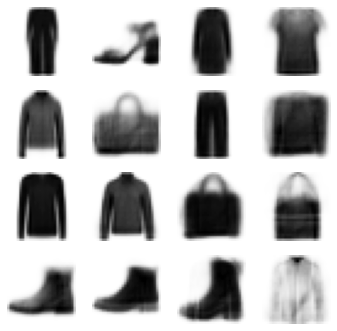

In [54]:
actual_noise = torch.randn((16, 196,)).cuda()
res = model.dec(actual_noise)
res = res.view(-1, 1, 28, 28).cpu()
show_images(res.sigmoid(), imsize=1.5)

We see something quite incredible. The VAE's decoder has learned to sample from the latent space _so effectively_ that an _actual random point in that space_, as long as it's sampled according to a Gaussian distribution, corresponds to something that, more often than not, looks like an image from the vector space of "real world black and white digital photographs of clothing with diverse shapes and types."

<AxesSubplot:title={'center':'Seriously, I would buy this shirt.'}>

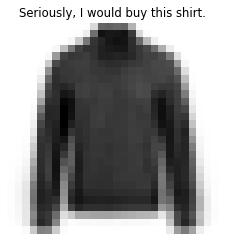

In [55]:
show_image(res[9].sigmoid(), title="Seriously, I would buy this shirt.")

# Diffusion

Lets move on now to creating a diffusion model with class guidance that will generate brand new images resembling the data in the training set. To make a proper latent diffusion model we would train the diffuser on the latents, because the computational and memory requirements can be extreme on high-dimensional data. We would, when dealing with high-resolution images, want to lower their dimensionality by running the images through an encoder, training a model to denoise the diffused latents, and then after sampling new latents using DDIM we would decode the samples into the brand new images. This is unnecessary for data as low-resolution as fashion-mnist's 28x28 pixel images, so we will diffuse and denoise source images directly.

## Forward (Diffusion) Process

These functions define the alphabar parameter which is used in both the diffusion and denoising directions in a DDIM model. Other parameters like betabar and variance parameters can be derived from them or supplied at sampling time.

This is a particular variation of the process which doesn't use discrete timesteps, but calculates alphabar on a squared cosine schedule where t is between 0 and 1.

In [57]:
'''
continous noise on cosine schedule
'''
def alphabar(t):
    return (t*math.pi / 2).cos()**2

'''
Inverse of above function
'''
def inv_alphabar(x):
    return x.sqrt().acos() * 2/math.pi

Now, the below function will be called during the data collation process. In other words, the dataloader will call it on every batch of training data, and the result of this function is interpreted as an (input, target) tuple so the model is trained to recieve "input" and produce "target".

input is also a (x_t, t, label) tuple, consisting of x_t, a version of the initial image with noised mixed in at a level corresponding to the timestep t, as well as the timestep t itself, and finally the class label of the image, so the model learns what noise to predict conditioned upon the class of the image (for fashion mnist, this is an integer 0-9 representing t-shit, bag, ankle boot, etc). Because default_collate(batch) gives us a batch where inputs and targets are represented as tensors containing each data point in a minibatch, these tuples contain tensors with outer dimension = batch_size, which we will verify below.

"diffusing" in this context can be understood as "noisification" and means advancing the image forward through time along a continuous Markov diffusion process. This diffusion process can be understood as advanced the image forward through time where at each step, we destroy a little bit of the information that was in the image at the previous step, by mixing in a little bit more random noise. Theoretically, if we had a model which could effectively reverse a single step in that process at any given timestep, we could start with actual random noise and move backwards step by step until we arrive at an image from the distribution of the training set. We shall endeavor to train a model to do just that.

The denoising model will learn to reverse the individual steps of this markov process, hence why its input is a partially noised image: its target is supposed to be the noise that was added during that timestep.

However, for computing the noised image at time t in the process, we don't need to iterate through all the previous steps, we can used a closed form solution that solves for what the image at that timestep would look like, which is what the "x_t = ..." line of code does.

In [58]:
def diffuse_batch_classcond(batch):
    batch = default_collate(batch)
    label = batch['label']
    x0 = batch['image'] # original un-diffused image
    dev = x0.device
    t = torch.rand((x0.shape[0],), device=dev).clamp(0,0.999)
    noise=torch.randn_like(x0)
    abar_t=alphabar(t)[:,None, None, None]
    x_t = abar_t.sqrt() * x0 + (1-abar_t).sqrt() * noise
    '''
    The "input" part of the resultant tuple is still a tuple because the denoising model will take 
    '''
    return ((x_t, t, label), noise)

Now let's create a new dataloader from our original dataset but now transformed to padded 32x32 images and collated through the diffuser. TF.to_tensor creates tensors with values in range \[0, 1\], but we'll center that data into the range \[-0.5, 0.5\] by subtracting 0.5.

## Data Preparation

In [59]:
batch_size_diffusion=256
@inplace
def transformi_diffuser(batch):
    batch['image'] = [
        F.pad(TF.to_tensor(im), (2, 2, 2, 2)) - 0.5
        for im in batch['image']
    ]

tds_diffusion = dsd.with_transform(transformi_diffuser)
dl_train = DataLoader(tds_diffusion['train'], batch_size_diffusion, collate_fn=diffuse_batch_classcond)
dl_valid = DataLoader(tds_diffusion['test'], batch_size_diffusion, collate_fn=diffuse_batch_classcond)

dls_diffusion = DataLoaders(dl_train, dl_valid)

Let's check that the shapes are what we expect. xt and added_noise should be (batch_size, 1, 32, 32) and t and lbl, each of which are supposed to contain just one number per item in a batch, should each be size (batch_size)

In [60]:
(xt, t, lbl), added_noise = next(iter(dls_diffusion.train))
xt.shape, t.shape, lbl.shape, added_noise.shape

(torch.Size([256, 1, 32, 32]),
 torch.Size([256]),
 torch.Size([256]),
 torch.Size([256, 1, 32, 32]))

And now let's look at some of our diffused ("noised") images at various timesteps. The larger timesteps have more information destroyed and look more like Gaussian noise.

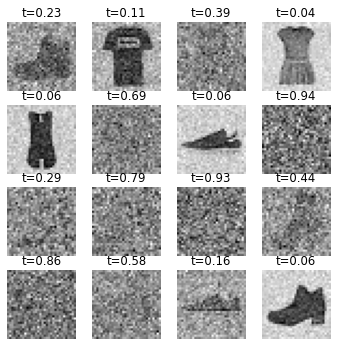

In [61]:
show_images(xt[:16], titles=[f't={ts.item():.2f}' for ts in t[:25]], imsize=1.5)

## Models: ResBlocks, Attention, and UNet

Now it's time to showcase the code which makes up the UNet, the backbone of DDIM. This will be the model that predicts what the noise was which was added to the image at a given timestep. It is a UNet composed of Residual Blocks. The Residual Blocks are composed of convolutional layers and may also have self-attention layers inside them. Timestep and class label information is embedded and combined in with the input x_t tensor (using scale and shift) in order to provide guidance to the model.

In [63]:
def timestep_embedding(timesteps, emb_dim, max_period=10_000):
    exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim //2, device = timesteps.device)
    emb = timesteps[:, None].float() * exponent.exp()[None, :]
    emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
    if emb_dim % 2 == 1:
        emb = F.pad(emb, (0, 1, 0, 0))
    
    return emb

This is the timestep embedding which serves the function of transforming an individual timestep value into an embedded vector with the property that similar timesteps have similar embeddings to one another. This reflects the fact that the model needs to do similar work for similar timestamps. Later on, when used in the denoiser's forward pass, even this embedding will be passed through further embedding layers and combined with other embeddings multiple times.

Here's what it looks like, where each row is an embedded vector for a successive timestep.

<AxesSubplot:>

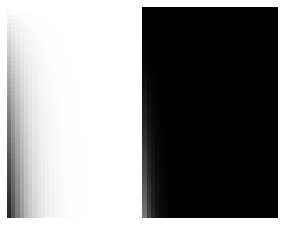

In [64]:
n_timesteps=50
n_embeddings=64
show_image(timestep_embedding(torch.linspace(0, 1, n_timesteps), n_embeddings))

Here we have a convolutional layer which has its normalization and activation layers _before_ the convolution.

In [65]:
def pre_conv(in_channels, out_channels, ks=3, stride=1, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm:
        layers.append(norm(in_channels))
    
    if act:
        layers.append(act())
    
    layers.append(nn.Conv2d(in_channels, out_channels, ks, stride, bias=bias, padding=ks//2))
    return layers

The up-path of the UNet will need to upsample images. In our UNet, when we downsample and upsample image sizes, it will always be by a factor of 2.

In [66]:
def upsample_and_conv(channels):
    return nn.Sequential(
        nn.Upsample(scale_factor=2.0),
        nn.Conv2d(channels, channels, kernel_size=3, padding=1) # padding == kernel_size // 2
    )

A layer which does activation and normalization before passing through a fully connected layer.

In [67]:
def pre_lin(n_inp, n_out, act=nn.SiLU, norm=None, bias=True):
    layers= nn.Sequential()
    if norm:
        layers.append(norm(n_inp))
    
    if act:
        layers.append(act())
    
    layers.append(nn.Linear(n_inp, n_out, bias=bias))
    return layers

all you need.

In [68]:
class SelfAttention2D(nn.Module):
    def __init__(self, channels, channels_per_head):
        super().__init__()
        self.n_heads = channels//channels_per_head
        '''
        We're doing multiheaded attention, but we can run x through the q, k, and v layers
        prior to splitting the transformed matrix into its heads.
        '''
        self.q = pre_lin(channels, channels)
        self.k = pre_lin(channels, channels)
        self.v = pre_lin(channels, channels)
        '''
        Let c = channels_per_head and p= "number of pixels". In forward pass, we'll compute s = q_x and k_x.t() where the matrices
        being multiplied have respective shapes (p, c) and (c, p). Assume because of weight initializaion and layer normalization 
        that q_x and k_x have 0 mean and unit variance.
        
        That means the result q_x@k_x.t() will have variance = c. Dividing the result by its standard deviation, sqrt(c),
        will thus return it to unit variance, preparing the result to undergo the softmax operation with less danger of some values
        predominating over all others, zero-ing them out and causing gradients to vanish.
        '''
        self.scale = math.sqrt(channels_per_head)
        self.last_lin = pre_lin(channels, channels)
        self.norm = nn.LayerNorm(channels)
    
    def forward(self, x):
        n, c, h, w = x.shape
        '''
        Flatten height and width into one vector and reshape so each image is shaped
        (pixels, channels)
        
        q_x, k_x, and v_x will also be (pixels,channels)
        
        channels will be "channels per head".
        '''
        x=x.view(n, c, h*w).transpose(1,2)
        x=self.norm(x)
        q_x=self.q(x)
        k_x=self.k(x)
        v_x=self.v(x)
        
        '''
        Now split Q(x), K(x), and V(x) matrices into different heads
        
        If there are 16 channels and we want 4 channels per head, we'll
        treat each block of 4 channels as an entirely different image so
        that different parameters are learned for that group of channels.
        One channel may need to "pay attention" to one region of pixels,
        while another channel needs to "pay attention" to an entirely diff-
        erent region. The different heads allow this.
        '''
        q_x,k_x,v_x = map(self._to_heads, (q_x, k_x, v_x))
        
        '''
        s size should now be (pixels, pixels)
        
        The output of attention, before running it through the last linear layer,
        is essentially that each pixel has its own dedicated weight vector over
        all other pixels, and that pixel will be turned into the weighted average
        of the other pixels in the same channel. That weight vector is s.
        
        Q and K are transformations of x where the model makes each channel vector into a
        linear combination of itself: in other words, during Q, K and V transforms,
        information may be shared, swapped, duplicated, removed, and combined 
        amongst channels in the same pixel, but no information can bleed between
        pixels.
        
        Then, to create the weight matrix s by taking Q@K.transpose, what we are
        doing is finding the dot products of the channels for each pixel. The question
        "what is Q(x) @ K(x).transpose" is then equivalent to asking, "for each pixel A,
        if we rebalance its channels amongst each other with mysteriously learned latent
        logic, how similar is it to another pixel B, whose channels have been rebalanced
        with equally mysterious latent logic?"
        
        That's because matrix multiplication is a certain type of "find a bunch of dot products
        between rows and columns," and dot product are another way of saying "how similar
        are these vectors."
        
        Knowing that degree of similarity between Q's mystery-channel-rebalanced pixels and
        K's mystery-rebalanced pixels, those similarities become the weight that is assigned
        to each pixel B when we fill pixel A with the weighted
        average of all other pixels.
        
        There is another interpretation of this using the metaphors of keys and queries,
        after which k and q are named.
        '''
        s = (q_x @ k_x.transpose(1, 2)) / self.scale
        
        '''
        Each column is a vector of weights, so the weights should add to 1. Hence, softmax().
        '''
        s = s.softmax(dim=-1)
        
        '''
        I lied a little. We don't really compose the output pixels as weighted averages of
        other pixels. Each pixel is a weighted average of "other pixels in the same channel
        whose channel values were rebalanced according to mysteriously learnt latent logic."
        It all makes sense, trust me, machine learning scientists really know what they're
        doing.
        '''
        result = s @ v_x
        result = self._to_batch(result)
        
        # we're doing skip connection outside of attention block, not inside it.
        return self.last_lin(result).view(n, c, h, w)
    
    def _to_heads(self, tsr):
        n_batch, n_sequence, n_channels = tsr.shape
        return tsr.transpose(1,2).reshape(n_batch*self.n_heads, n_channels//self.n_heads, n_sequence).transpose(1,2)
    
    def _to_batch(self, tsr):
        n_batch, n_sequence, n_channels = tsr.shape
        return tsr.transpose(1, 2).reshape(n_batch//self.n_heads, n_channels*self.n_heads, n_sequence).transpose(1,2)

Residual block, a la [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), with support for self-attention and embedded guidance.

The concept of a ResBlock is to formulate the desired function f(x) for a layer as being f(x) = r(x) + x. By adding either x, or some data which closely resembles x (since the dimension of the output might be different from the input) to the output before returning, the parameters in the ResBlock learn the residual function, r(x), which He at al discovered to be in many cases an easier task to perform than learning the goal function directly.

Additionally, the EmbResBlock receives an embedded vector that contains guidance information (e.g. embedded timestep plus embedded class label, for instance). Pass the embedding through a custom learnt linear layer to get scale and shift values, so the layer can both scale and shift each channel by a single amount. In other words, for 8 channels, the input embedding will ultimately be transformed into 8 scaling numbers and 8 shifting numbers which will respectively be applied to each input channel separately.

Finally, self-attention is optionally applied. The UNet will enable self-attention for ResBlocks with smaller height/width inputs, since self-attention is a computationally expensive process with regard to image height/width. A form of residual self-attention is applied, where the output of the preceding layers inside the ResBlock is added to the output of the attention layer using the formulation f(x) = x + attn(s). This matters especially for attention, I think, because it allows the self-attention layer to not have to "worry about" letting pixels attend to themselves, and the use of softmax in the weight matrix inside of attention makes it difficult for self-attention to "worry about" too many things at once. (The exponential nature of the numerator in a softmax function means it's very hard to avoid one value dominating over all other values in the softmax output).

In [69]:
class EmbResBlock(nn.Module):
    def __init__(self, n_emb, in_channels, out_channels, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d, channels_per_attn_head=0):
        super().__init__()
        self.in_channels=in_channels
        self.out_channels=out_channels
        
        # half the result of this will be used to scale, the other half to shift
        self.emb_lin = nn.Linear(n_emb, out_channels * 2)
        self.conv1 = pre_conv(in_channels, out_channels, ks, act=act, norm=norm)
        self.conv1.in_channels = in_channels
        self.conv1.out_channels = out_channels
        self.conv2 = pre_conv(out_channels, out_channels, ks, act=act, norm=norm)
        
        '''
        ResBlocks, as used in this model, are not used for up- or down- sampling,
        but can change channel count, hence the possible need for self.idconv
        '''
        self.idconv = fc.noop if in_channels==out_channels else nn.Conv2d(out_channels, out_channels, 1)
        
        if channels_per_attn_head > 0:
            self.attn_layer = SelfAttention2D(out_channels, channels_per_attn_head)
        else:
            self.attn_layer = None
    
    def forward(self, x, emb):
        inp = x
        # import pdb; pdb.set_trace()
        x=self.conv1(x)
        t_emb=self.emb_lin(F.silu(emb))
        scale,shift = torch.chunk(t_emb[:, :, None, None], 2, dim=1)
        x= x*(1+scale) + shift
        x=self.conv2(x)
        
        # The first residual
        x=x+self.idconv(x)
        
        if self.attn_layer:
            # a second residual layer dedicated to attention
            x=x + self.attn_layer(x)
        return x
        

This function essentially acts as a decorator around a ResBlock which captures input/output and appends it to a list that is stored on a different object.

May serve two purposes:
- saving the outputs of blocks in the downlayer in order to use them for the concatenation connections to the opposite upblocks in the UNet 
- capturing the sizes of in/out tensors for later debugging to make sure blocks at each layer are receiving and producing tensors of the correct dimensionality.

In [70]:
def saved(module, block, save_in=False):
    fwd = module.forward
    
    # is this annotation needed?
    # @wraps(module.forward)
    def _f(*args, **kwargs):
        out = fwd(*args, **kwargs)
        
        block.saved_out.append(out)
        
        # saved input only for debugging purposes
        if save_in:
            block.saved_in.append(args[0])
        return out
    
    module.forward = _f
    return module

Downblock with attention. The down-path of the UNet is composed of a series of these DownBlocks. Each DownBlock takes in a tensor with a certain number of channels, will downsample it to half its height and width if it's _not_ the final downblock in the UNet, and will use ResBlocks to expand the number of channels.

The ResBlocks are wrapped in the saved() function which returns a kind of decorator that saves their outputs to a list stored as an attribute on the block itself.

The horizontal skip connections of the UNet occur between each corresponding ResBlock, so the outputs of each ResBlock here are saved to be concatenated to the inputs to ResBlocks which are inside corresponding UpBlocks on the up-path of the UNet.

In [71]:
class DownBlock(nn.Module):
    def __init__(self, n_t_emb, in_channels, out_channels, is_final_down=False, num_layers=1, channels_per_head=0):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        # make EmbResNets
        self.erbs = []
        for i in range(0, num_layers):
            # first erb expands channels, subsequent ones keep it constant
            erb_in_channels = in_channels if i==0 else out_channels
            erb=EmbResBlock(n_t_emb, erb_in_channels, out_channels, channels_per_attn_head=channels_per_head)
            self.erbs.append(saved(erb, self))
        self.erbs = nn.ModuleList(self.erbs)
        
        # only downsample if not the final downblock
        self.is_final_down=is_final_down
        if not self.is_final_down:
            kernel_size=3
            down_conv = nn.Conv2d(out_channels, out_channels, kernel_size, stride=2, padding=kernel_size//2)
            self.down_conv = saved(down_conv, self)
        else:
            self.down_conv = None
            
    def forward(self, x, emb):
        # saved io only needed during scope of a single forward pass through module. The next time
        # forward is called will be the next minibatch at which the data needs to be reset.
        self.saved_in=[]
        self.saved_out=[]
        for erb in self.erbs:
            x = erb(x, emb)
        
        if not self.is_final_down:
            x = self.down_conv(x)
        
        return x

The up-path of the UNet is comopsed of a series of these UpBlocks. It is, in many ways, symmetrical with the DownBlock: its job is to use a series of ResBlocks to decrease channel count while upsampling image size back to original size. The key difference is that, the input of each ResBlock can take input both coming "upward" from the block immediately preceding this UpBlock, and also input that "cuts across" horizontally from the opposite side of UNet, from the down-path. This happens in the forward pass by means of concatenating these two tensors on the channel dimension.

In [72]:
class UpBlock(nn.Module):
    def __init__(self, n_t_emb, prev_block_out_chans, skip_in_channels_ls, out_channels, is_final_up=False, num_layers=1, channels_per_head=0):
        super().__init__()
        self.in_channels = prev_block_out_chans
        self.out_channels = out_channels
        
        num_layers = len(skip_in_channels_ls)
        
        # make EmbResNets
        self.erbs = []
        for i in range(0, num_layers):
            
            '''
            if first erb in block, then data coming upward through the block will have come from the previous block
            
            otherwise will be from the last erb in *this* block
            '''
            if i==0:
                upward_in_channels=prev_block_out_chans
            else:
                upward_in_channels=out_channels
                
            '''
            skip connection is input concatenated on the channel dimension, so each erb must take channels
            equal to those from the data being passed up plus those from the data being concatenated onto it
            '''
            erb_in_channels = upward_in_channels + skip_in_channels_ls[i]
            erb=EmbResBlock(n_t_emb, erb_in_channels, out_channels, channels_per_attn_head=channels_per_head)
            self.erbs.append(saved(erb, self))
        self.erbs = nn.ModuleList(self.erbs)
        
        # only upsample if not the final upblock
        self.is_final_up=is_final_up
        if not self.is_final_up:
            up_conv = upsample_and_conv(out_channels)
            self.up_conv = saved(up_conv, self)
        else:
            self.up_conv = None
            
    def forward(self, x, emb, skip_conns):
        self.saved_in=[]
        self.saved_out=[]
        for erb in self.erbs:
            x = erb(torch.cat([x, skip_conns.pop()], dim=1), emb)
        
        if not self.is_final_up:
            x = self.up_conv(x)
        return x

The UNet.

In [73]:
class CondEmbUNetModel(nn.Module):
    def __init__(self, num_classes, in_channels=1, out_channels=1, block_channel_counts=(32,64, 128, 256), num_layers=1, channels_per_head=8, attn_start=1):
        super().__init__()
        # in conv
        self.first_conv = conv(in_channels, block_channel_counts[0], stride=1, act=False)
        self.first_conv.in_channels=in_channels
        self.first_conv.out_channels=block_channel_counts[0]
        
        # timestep embedding
        '''
        length of embedding produced by initial timestep embedding
        only used to produce transformed t embeddings
        
        this size doesn't particularly have to match any channel size because it will
        get re-transformed by the MLP
        '''
        self.t_emb_sz = block_channel_counts[0]
        
        '''
        length of embedding to be passed in to all ERBs in all 
        down and up blocks.
        
        This will be the size of the single information embedding which will be the sum
        of the class embedding and the mlp-transformed time-embedding
        '''
        final_emb_sz = self.t_emb_sz * 4
        
        self.t_emb_mlp = nn.Sequential(pre_lin(self.t_emb_sz, final_emb_sz, norm=nn.BatchNorm1d),
                                  pre_lin(final_emb_sz, final_emb_sz))
        
        # class embedding
        '''
        nn.Embedding used because it does one-hot encoding itself, takes an index in forward pass
        and produced embedded vector
        '''
        self.c_emb = nn.Embedding(num_classes, final_emb_sz)
        
        # down blocks
        num_blocks = len(block_channel_counts)
        final=False
        self.downblocks = []
        down_in_channels = block_channel_counts[0]
        for i in range(num_blocks):
            if i==num_blocks - 1:
                final = True
            down_out_channels = block_channel_counts[i]
            erb_channels_per_head = channels_per_head if i >= attn_start else 0
            block = DownBlock(final_emb_sz, down_in_channels, down_out_channels, final, num_layers, erb_channels_per_head)
            down_in_channels=down_out_channels
                              
            self.downblocks.append(block)
            
        self.downblocks = nn.ModuleList(self.downblocks)
        
        # mid block
        self.midblock = EmbResBlock(final_emb_sz, block_channel_counts[-1], block_channel_counts[-1], channels_per_attn_head=channels_per_head)
        
        # up blocks
        
        '''
        calculate the channels of skip connections:
        
        start with a single entry of first channel block size (output of first_conv)
        
        subsequently for all but last downblock, add (num_layers+1) copies of corresponding channel count for block,
        for the num_layers of resblock and the 1 downsampling layer, all of which produce the same out_channels
        
        finally add num_layers copies of the final block channel_out, because last downblock has no downsampling
        
        length of list will be, therefore, 1 + (num_blocks-1)*(num_layers+1) + num_layers = num_blocks*(num_layers+1),
        with (num_layers+1) being the number of skip connections going into each upblock
        '''
        skip_conn_channels=[block_channel_counts[0]]
        for i in range(num_blocks - 1):
            skip_conn_channels = skip_conn_channels + (num_layers+1) * [block_channel_counts[i]]
        skip_conn_channels = skip_conn_channels + num_layers * [block_channel_counts[-1]]
        
        skips_per_block = num_layers+1
        skip_conn_channels = list(reversed(skip_conn_channels))
        skip_conn_channels = [skip_conn_channels[i: i+skips_per_block] for i in range(0, len(skip_conn_channels), skips_per_block)]
        self.skip_conn_channels = skip_conn_channels
            
        prev_channels = block_channel_counts[-1]
        final = False
        self.upblocks=[]
        for i in range(num_blocks):
            if i==num_blocks-1:
                final = True
            
            erb_channels_per_head = channels_per_head if i < (num_blocks - attn_start) else 0
            up_out_channels=block_channel_counts[-(i+1)]
            block = UpBlock(final_emb_sz, prev_channels, skip_conn_channels[i], up_out_channels, final, num_layers+1, erb_channels_per_head)
            self.upblocks.append(block)
            prev_channels = up_out_channels
        
        self.upblocks = nn.ModuleList(self.upblocks)
        
        # last conv
        self.last_conv= pre_conv(block_channel_counts[0], out_channels, stride=1, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)
        self.last_conv.in_channels = block_channel_counts[0]
        self.last_conv.out_channels = out_channels
        
    '''
    Model takes t tensor with a different timestep for each image, shape [batch_size]
    '''
    def forward(self, inp):
        x, t, c = inp
        t_emb = timestep_embedding(t, self.t_emb_sz)
        c_emb = self.c_emb(c)
        '''
        t is "double embedded" first from a
        '''
        generic_emb = self.t_emb_mlp(t_emb) + c_emb
        x = self.first_conv(x)
        skip_conns = [x]
        for block in self.downblocks:
            x = block(x, generic_emb)
            skip_conns = skip_conns + block.saved_out
        
        x = self.midblock(x, generic_emb)
        
        for block  in self.upblocks:
            x = block(x, generic_emb, skip_conns)
        
        return self.last_conv(x)
        

## Training

In [ ]:
lr = 1e-2
model = CondEmbUNetModel(10, in_channels=1, out_channels=1, block_channel_counts=(32,64,128,256), num_layers=2)
adam_opt = partial(optim.Adam, eps=1e-5)
learn = Learner(model, dls_diffusion, nn.MSELoss(), lr=lr, cbs=[DeviceCB(), MixedPrecision()], opt_func=adam_opt)
learn.lr_find()

loss,epoch,train
0.156,0,train
0.078,0,eval
0.066,1,train
0.057,1,eval
0.052,2,train
0.056,2,eval
0.047,3,train
0.051,3,eval
0.044,4,train
0.042,4,eval


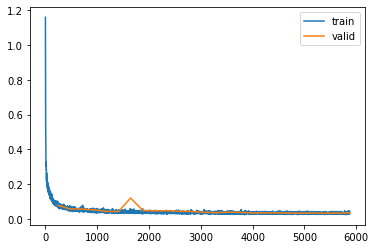

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [48]:
'''
Conditional model! bs=256.
'''
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls_diffusion.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = CondEmbUNetModel(10, in_channels=1, out_channels=1, block_channel_counts=(32,64,128,256), num_layers=2)
learn = Learner(model, dls_diffusion, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

learn.fit(epochs)

In [81]:
denoising_model = CondEmbUNetModel(10, in_channels=1, out_channels=1, block_channel_counts=(32,64,128,256), num_layers=2)
denoising_model.load_state_dict(torch.load('models/2024-01-30-condunet-statedict-demo-cneifs.pkl'))
denoising_model = denoising_model.cuda()

## Backward (DDIM Denoising) Process

Remember that one step in the Markov diffusion process which destroys information in an image and turns it more closely into Gaussian noise. Given, as a paramter, the noise which was added in a timestep t in the diffusion process, this step reverses the diffusion step, and removes that noise added in that step. The noise given as a parameter to this function should come from the denoising model that we've trained above, which has learned how to receive an image x_t at timestep t (with a given label) and predict what noise was mixed into it at that timestep.

As part of calculating the new xt, or xt at the previous timestep, we also calculate an estimation of what the original image looked like before *any* noise was added in. This is x0hat. By the time we've reached the end of the process calling this denoising step iteratively for successively decreasing timestep values, the x0hat prediction should be quite good.

TODO: capture all x0hat preds to show progression

In [77]:
def ddim_step(x_t, noise, alphabar_t, alphabar_tm1, eta, clamp=True):
    betabar_t = 1 - alphabar_t
    betabar_tm1 = 1 - alphabar_tm1
    sigma = ((betabar_tm1 / betabar_t).sqrt() * (betabar_t /alphabar_tm1).sqrt()) * eta
    '''
    image as derived from predicted noise
    '''
    x0hat = (x_t - noise*betabar_t.sqrt()) /alphabar_t.sqrt() 
    
    if clamp:
        x0hat = x0hat.clamp(-1, 1)
        
    if betabar_tm1 <= sigma**2 + 0.01:
        sigma = 0.0
    
    x_t =alphabar_tm1.sqrt() * x0hat + (betabar_tm1 - sigma**2).sqrt() * noise
    x_t += sigma * torch.randn(x_t.shape).to(x_t.device)
    
    return x0hat, x_t

This function performs the whole backwards, reverse diffusion process, starting with pure Gaussian noise in the shape of the image we want, and iteratively taking steps backwards to denoise it at successively decreasing timesteps until what we have at the end of the denoising process (in other words, the "beginning" of the diffusion process) is an image which is a datapoint sampled at random from the distribution of the training set, conditioned on it being a member of the class indicated.

In [89]:
'''
Return a list of what the "best approximation" of the final image is at each timestep. The final 
image in the list will be the final result, the others are meant for demonstration to show the
progression of the denoising process.
'''
def cond_sample(clas, denoise_fn, denoise_mdl, sz, steps, eta=1., clamp=True):
    x0hat_samples = []
    clas = torch.tensor(clas).cuda()[None]
    denoise_mdl.eval()
    xt = torch.randn(sz).cuda()
    step_sz = 1/steps
    ts = torch.linspace(1-step_sz, 0, steps).cuda()
    for i,t in enumerate(progress_bar(ts)):
        with torch.no_grad():
            pred_noise = denoise_mdl((xt, t[None], clas))
            alphabar_t=alphabar(t)
            alphabar_tm1=alphabar(t - step_sz) if t >= step_sz else torch.tensor(1).cuda()
            x0hat, xt = denoise_fn(xt, pred_noise, alphabar_t, alphabar_tm1, eta, clamp=clamp)
            x0hat_samples.append(x0hat.float().cpu())
    return x0hat_samples

## Demo

Before checking out a sampling of images across all the categories, let's just generate one photo, and then look at how the sampling method makes iterative progress towards approximating a real image going "backward" in time.

In [92]:
t_shirt_category=0
steps=100

'''
each item in list is a tensor representing a batch of images, but we've requested a batch of just one image, so
extract that image from each batch
'''
t_shirt_samples = [batch[0] for batch in cond_sample(t_shirt_category, ddim_step, denoising_model, (1, 1, 32, 32), 100)]

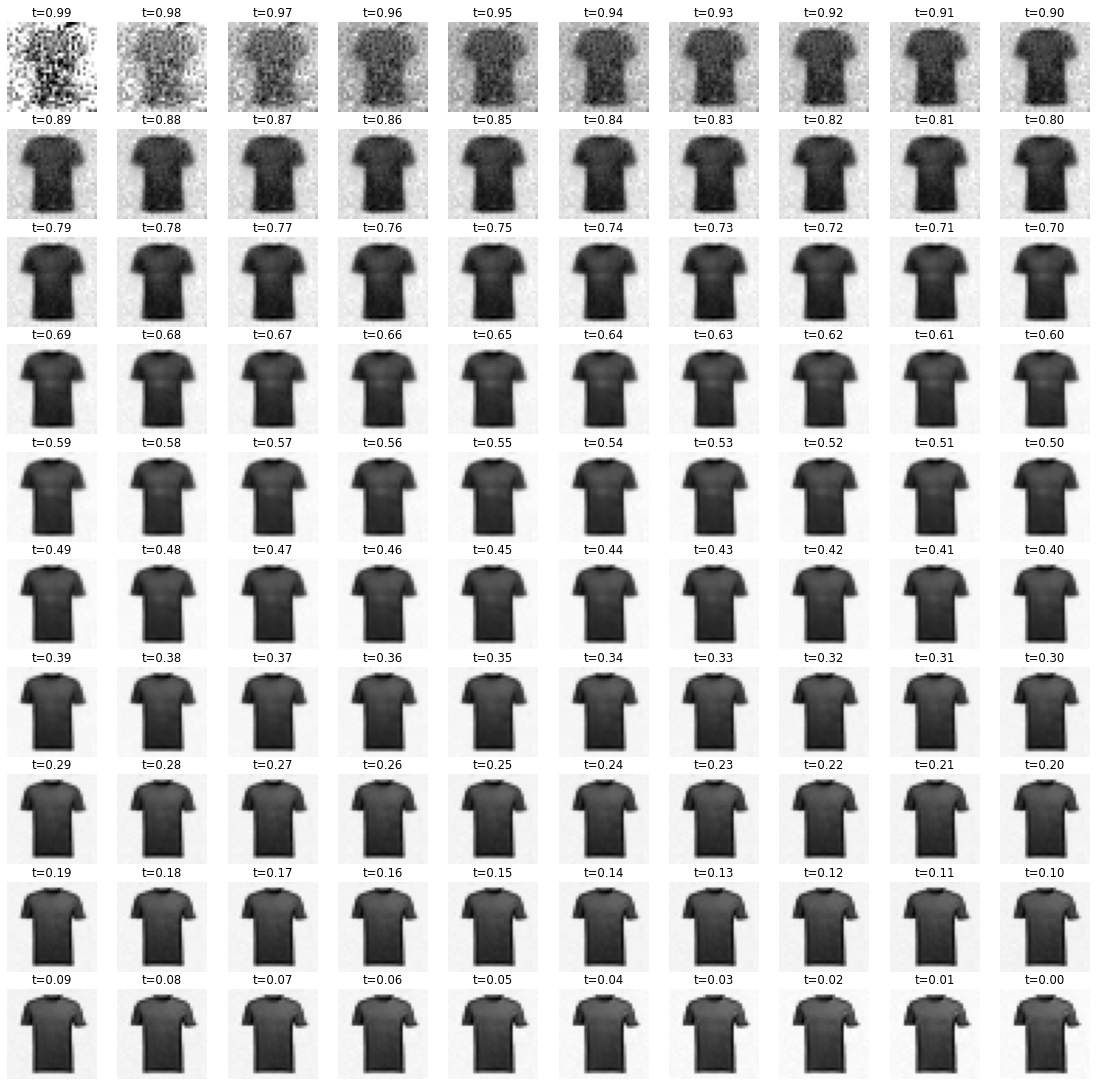

In [94]:
'''
Re-create the series of timesteps used for each step, to annotate the image progression
'''
step_sz = 1/steps
timesteps = torch.linspace(1-step_sz, 0, steps).cuda()

show_images(t_shirt_samples, titles=[f't={ts.item():.2f}' for ts in timesteps], imsize=2)

Quick reminder that the following is the mapping of what clothing category each integer class label represents.

In [79]:
lbl_names = dsd['train'].features['label'].names
lbl_names = {k:v for k,v in enumerate(lbl_names)}
lbl_names

{0: 'T - shirt / top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

Let's generate 16 images from each of the ten clothing categories.

In [86]:
samples = []
for clothing_category in range(0, 10):
    pass
    # samples.append(cond_sample(clothing_category, ddim_step, denoising_model, (16, 1, 32, 32), 100))
# saveobj(samples, 'classcond-samples-fmnist')
samples = torch.load('models/2024-01-30-classcond-samples-fmnist-2f2aeca4.pkl')

And what we see below are the fictitious, created-from-random noise images we've generated from our model. Some are not very good, others are quite good!

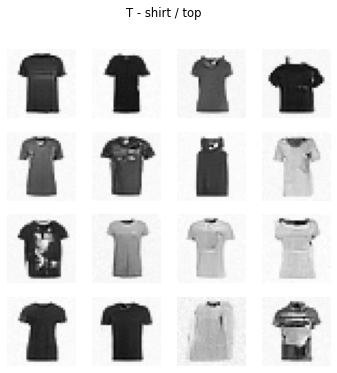

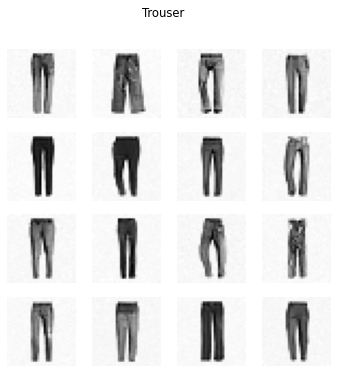

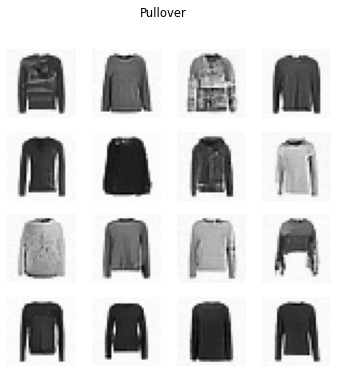

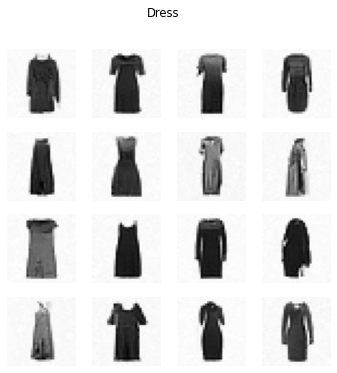

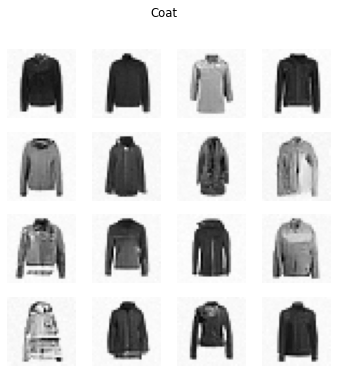

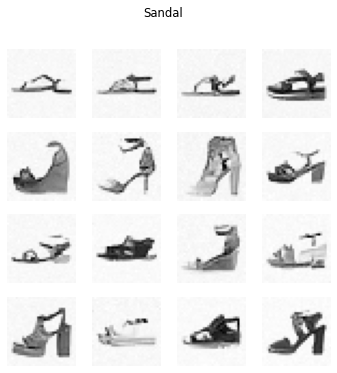

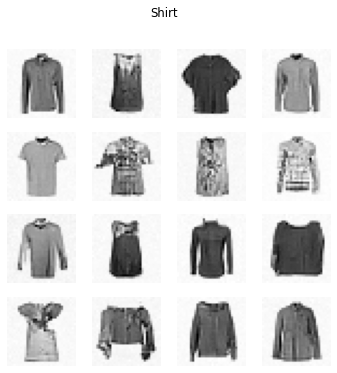

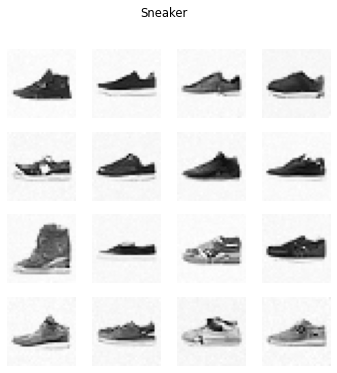

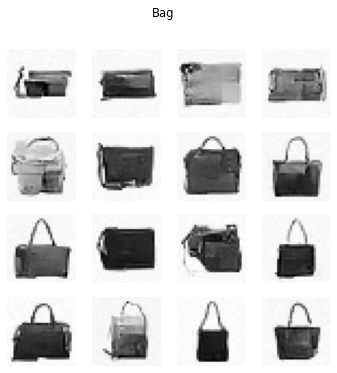

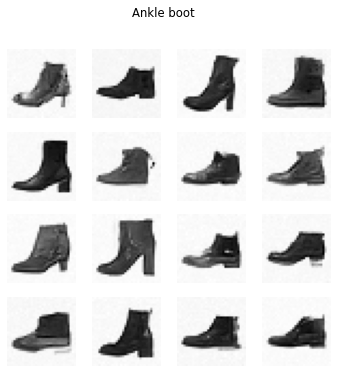

In [87]:
for i in range(0, 10):
    show_images(samples[i], imsize=1.5, suptitle=lbl_names[i])